In [2]:
import cv2
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import sklearn
import keras
from keras import layers 

In [3]:
df=pd.read_csv('data/driving_log.csv',names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

In [4]:
df.shape

(6967, 7)

(array([ 527., 5982.,  458.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <a list of 3 Patch objects>)

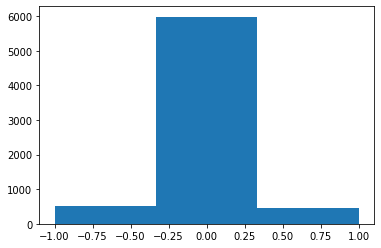

In [17]:
plt.hist(df['steering'],bins=3)

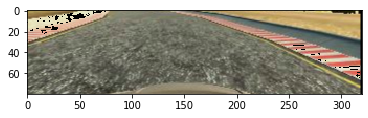

In [18]:
x=df['center'].loc[7]
x=cv2.imread(x)
x=cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
#x=cv2.resize(x,(100,100),interpolation=cv2.INTER_AREA)
x= random_flip(x)
x=random_translate(x)
x=random_brightness(x)
x=random_brightness(x)
x=x[60:140, :, :]
x=(x/255)
plt.imshow(x)

In [5]:
def random_flip(image):
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
    return image
def random_translate(image, range_x=50, range_y=20):
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image
def random_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.2 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
def random_shadow(image):
    """
    Generates and adds random shadow
    """
    IMAGE_WIDTH=320
    IMAGE_HEIGHT=160
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

In [6]:
y = df['steering']


In [7]:
train=df['center'].values
train.shape

(6967,)

In [11]:
center_images=[]
for i in range(len(train)):
    x=cv2.imread(train[i])
    x=cv2.cvtColor(x,cv2.COLOR_BGR2YUV)
    #x=cv2.resize(x,(100,100),interpolation=cv2.INTER_AREA)
    x=random_flip(x)
    x=random_translate(x)
    x=random_shadow(x)
    x=random_brightness(x)
    x=x[60:140, :, :]
    x=(x/255)
    center_images.append(x)
    
        
        


In [20]:
np.shape(X_train)

(5225, 80, 320, 3)

In [17]:
import gc
gc.collect()

81

In [19]:
center_images= np.array(center_images)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(center_images, y , test_size=0.25, random_state=0,shuffle=True)

In [21]:
IMG_SHAPE = (80, 320, 3)

In [22]:
from keras.layers import Input,Dense,Conv2D,Flatten,Dropout
from keras.models import Model
from keras.layers.convolutional import MaxPooling2D
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint

In [25]:
inputs=Input(shape=IMG_SHAPE)
out1=Conv2D(16,(3,3),activation='relu')(inputs)
max1= MaxPooling2D(pool_size=(2, 2))(out1)
max1=BatchNormalization()(max1)
max1=Dropout(0.1)(max1)
out2=Conv2D(32,(3,3),activation='relu')(max1)
max2= MaxPooling2D(pool_size=(2, 2))(out2)
max2=BatchNormalization()(max2)
ff=Flatten()(max2)
d1=Dense(100,activation='relu')(ff)
d2=Dense(50,activation='relu')(d1)
avg=Dense(10,activation='relu')(d2)

pred=Dense(1,activation=None)(avg)

model=Model(inputs=inputs,outputs=pred)
model.compile(optimizer=optimizers.Adam(lr=0.0001,decay=1e-6),
              loss='mse',
              metrics=['mse'])


In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 78, 318, 16)       448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 159, 16)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 39, 159, 16)       64        
_________________________________________________________________
dropout_3 (Dropout)          (None, 39, 159, 16)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 157, 32)       4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 78, 32)        0         
__________

In [27]:
file_path="model7.h5"
checkpoint=ModelCheckpoint(file_path,monitor='val_loss',save_best_only='True',mode="max")
call_back2=[checkpoint]
hist=model.fit(x=X_train,
                y=y_train,
                epochs=7,
                verbose=1,
                batch_size=32,
                validation_data=(X_valid,y_valid),
               callbacks=call_back2)

Instructions for updating:
Use tf.cast instead.
Train on 5225 samples, validate on 1742 samples
Epoch 1/7
5225/5225 [==============================] - 172s 33ms/step - loss: 0.1550 - mean_squared_error: 0.1550 - val_loss: 0.1022 - val_mean_squared_error: 0.1022
Epoch 2/7
5225/5225 [==============================] - 174s 33ms/step - loss: 0.0971 - mean_squared_error: 0.0971 - val_loss: 0.0857 - val_mean_squared_error: 0.0857
Epoch 3/7
5225/5225 [==============================] - 172s 33ms/step - loss: 0.0906 - mean_squared_error: 0.0906 - val_loss: 0.0787 - val_mean_squared_error: 0.0787
Epoch 4/7
5225/5225 [==============================] - 175s 34ms/step - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0787 - val_mean_squared_error: 0.0787
Epoch 5/7
5225/5225 [==============================] - 174s 33ms/step - loss: 0.0925 - mean_squared_error: 0.0925 - val_loss: 0.0735 - val_mean_squared_error: 0.0735
Epoch 6/7
5225/5225 [==============================] - 176s 34ms/step - lo

In [28]:
base_model = keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [29]:
base_model.trainable = True

In [31]:
fine_tune = 15
for layer in base_model.layers[:fine_tune]:
  layer.trainable =  False

In [32]:
from keras import models
model2 = models.Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation=None))

In [33]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 10, 512)        14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1310848   
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total para

In [34]:
model2.compile(optimizer=optimizers.Adam(lr=1e-3,decay=1e-5,beta_1=0.99,beta_2=0.999),
              loss='mse',
              metrics=['mse'])

In [37]:
file_path="model10.h5"
checkpoint=ModelCheckpoint(file_path,monitor='val_loss',save_best_only='True',mode="max")
call_back2=[checkpoint]
hist=model2.fit(x=X_train,
                y=y_train,
                epochs=3,
                verbose=1,
                batch_size=8,
                validation_data=(X_valid,y_valid),
               callbacks=call_back2)

Train on 5225 samples, validate on 1742 samples
Epoch 1/3
5225/5225 [==============================] - 1697s 325ms/step - loss: 0.1485 - mean_squared_error: 0.1485 - val_loss: 0.0854 - val_mean_squared_error: 0.0854
Epoch 2/3
5225/5225 [==============================] - 1681s 322ms/step - loss: 0.0992 - mean_squared_error: 0.0992 - val_loss: 0.0875 - val_mean_squared_error: 0.0875
Epoch 3/3
5225/5225 [==============================] - 1697s 325ms/step - loss: 0.1113 - mean_squared_error: 0.1113 - val_loss: 0.0828 - val_mean_squared_error: 0.0828
